Optimized scaling values for 1pct-brch-1000PgC:  0.8444349269645157 1.751277261351873 8.719175128552305
Optimized scaling values for 1pct-brch-2000PgC:  3.2246822663290238 3.5214086802753937e-19 6.327443548984244


/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_45468/1334635616.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scale_values_df = pd.concat([scale_values_df, new_scale_values], ignore_index=True)


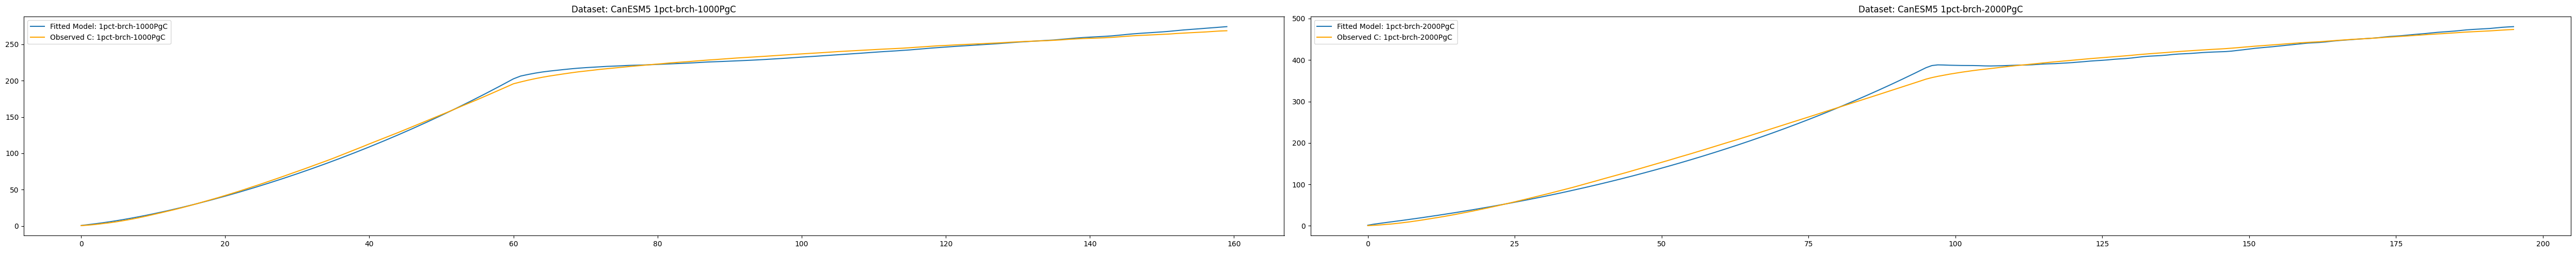

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.lib import recfunctions
from scipy.optimize import curve_fit

# Define the step temperature function
def step_temperature_e(S_old, F, q, d, dt=1):
    decay_factor = np.exp(-dt / d)
    S_new = q * F * (1 - decay_factor) + S_old * decay_factor
    T = np.sum((S_old + S_new) / 2)
    return S_new, T

# Define the fitting function
    
def only_leave_params_to_be_set(time, alpha, beta, gamma, conc_data):
    q_test = np.array([0.180 * alpha, 0.297 * beta, 0.386 * gamma])  # q values
    d_test = np.array([0.903, 7.92, 355]) # d values (set)
    C_test_values = np.array(conc_data - conc_data[0], dtype=float)
    C_output = np.zeros(len(C_test_values), dtype=float)

    S_test, C_output[0] = step_temperature_e(S_old=0, F=np.sum(C_test_values[0]), q=q_test, d=d_test, dt=1)

    for t in range(1, len(C_test_values)):
        S_test, C_output[t] = step_temperature_e(S_old=S_test, F=np.sum(C_test_values[t]), q=q_test, d=d_test, dt=1)

    return C_output.astype(float)

def step_temp_model_fitting_procedure(fgco2, conc, datasets, dataset_name, scale_values_df):

    # Set up subplots for plotting
    fig, ax = plt.subplots(1, len(datasets), figsize=(50, 5))

    bounds = (0, [np.inf, np.inf, np.inf])
    p0=[1, 1, 1]

    for i, label in enumerate(datasets):
        fgco2_data = fgco2[label]
        C = np.cumsum(fgco2_data)

        conc_data = conc[label]
        time = np.arange(len(conc_data))
    
        # Ensure consistent length for fitting
        min_length = min(len(C), len(conc_data))
        C = C[:min_length]
        conc_data = conc_data[:min_length]
        time = time[:min_length]

        # Fit the curve
        popt, pcov = curve_fit(lambda t, alpha, beta, gamma: only_leave_params_to_be_set(t, alpha, beta, gamma, conc_data), 
                       time, C, p0=p0, bounds=bounds)
    
        # Optimized parameters
        alpha_opt, beta_opt, gamma_opt = popt
    
        print(f"Optimized scaling values for {label}: ", alpha_opt, beta_opt, gamma_opt)

        # Append q values to the DataFrame
        new_scale_values = pd.DataFrame({'Dataset': [f'{dataset_name}'], 'Experiment': [label], 'alpha': [alpha_opt], 'beta': [beta_opt], 'gamma': [gamma_opt]})
    
        # Concatenate the new q values to the main scale_values_df DataFrame
        scale_values_df = pd.concat([scale_values_df, new_scale_values], ignore_index=True)
        # Output C with optimized parameters
        C_output_optimized = only_leave_params_to_be_set(time, alpha_opt, beta_opt, gamma_opt, conc_data)

        # Plot the fitted curve and observed data
        ax[i].plot(time, C_output_optimized, label=f'Fitted Model: {label}')
        ax[i].plot(time, C, 'orange', label=f'Observed C: {label}')
        ax[i].set_title(f'Dataset: {dataset_name} {label}')
        ax[i].legend()
    

    # Adjust layout and show plot
    plt.tight_layout()
    plt.savefig(f'just q Dataset: {dataset_name}')
    return plt, scale_values_df


# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CanESM5/CanESM/fgco2_CanESM5_esm-1pct-brch-1000PgC_1851_2010.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/CanESM5/CanESM/fgco2_CanESM5_esm-1pct-brch-2000PgC_1947_2010.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CanESM5/CanESM/co2_CanESM5_esm-1pct-brch-1000PgC_1851_2010.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/CanESM5/CanESM/co2_CanESM5_esm-1pct-brch-2000PgC_1947_2010.csv', index_col=0).to_numpy().flatten(),
}

scale_values_df = pd.DataFrame(columns=['Dataset', 'Experiment', 'alpha', 'beta', 'gamma'])

plt , scale_values_df = step_temp_model_fitting_procedure(fgco2 = fgco2, conc = conc, datasets = datasets, dataset_name = 'CanESM5', scale_values_df = scale_values_df)


Optimized scaling values for 1pctCO2:  4.490354670621321 8.580126283766965e-17 9.7334094524931e-18
Optimized scaling values for 1pct-brch-1000PgC:  1.4097838469479516 1.6209345166407851 9.024242110759667
Optimized scaling values for 1pct-brch-750PgC:  0.15951150524226815 2.5257231287015873 10.16232694158155
Optimized scaling values for 1pct-brch-2000PgC:  3.763160751736795 7.846199473426879e-21 4.778599339034156


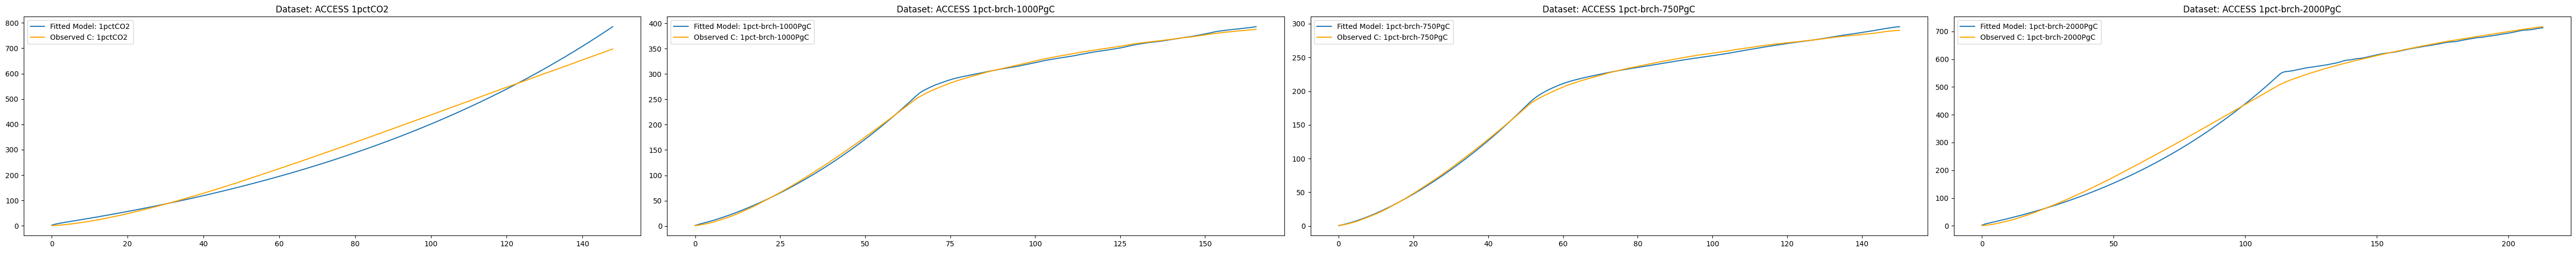

In [186]:
# Load data
datasets = ['1pctCO2', '1pct-brch-1000PgC', '1pct-brch-750PgC', '1pct-brch-2000PgC']

fgco2 = {
    '1pctCO2': pd.read_csv('all_zecmip/ACCESS/ACCESS_1pct/fgco2_ACCESS-ESM1.5_A1_1-150.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/ACCESS/ACCESS_A1/fgco2_ACCESS-ESM1.5_esm-1pct-brch-1000PgC_68-167.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/ACCESS/ACCESS_A2/fgco2_ACCESS-ESM1.5_esm-1pct-brch-750PgC_54-153.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/ACCESS/ACCESS_A3/fgco2_ACCESS-ESM1.5_esm-1pct-brch-2000PgC_116-215.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pctCO2': pd.read_csv('all_zecmip/ACCESS/ACCESS_1pct/co2_ACCESS-ESM1.5_A1_1-150.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/ACCESS/ACCESS_A1/co2_ACCESS-ESM1.5_esm-1pct-brch-1000PgC_68-167.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/ACCESS/ACCESS_A2/co2_ACCESS-ESM1.5_esm-1pct-brch-750PgC_54-153.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/ACCESS/ACCESS_A3/co2_ACCESS-ESM1.5_esm-1pct-brch-2000PgC_116-215.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = step_temp_model_fitting_procedure(fgco2 = fgco2, conc = conc, datasets = datasets, dataset_name = 'ACCESS', scale_values_df = scale_values_df)


Optimized scale values for 1pct-brch-1000PgC:  0.8021063496684807 1.6442298784007308 8.416718291042477


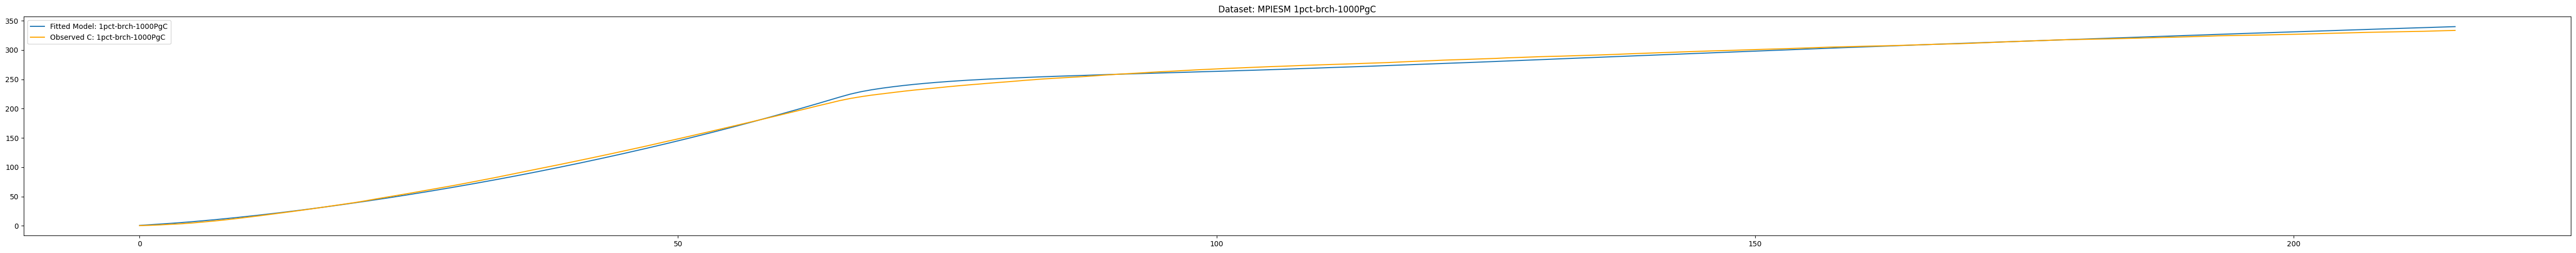

In [187]:
# Load data
datasets = ['1pct-brch-1000PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CESM/CESM_A1/fgco2_cesm2_esm-1pct-brch-1000PgC_0001_0150.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CESM/CESM_A1/co2_cesm2_esm-1pct-brch-1000PgC_0001_0150.csv', index_col=0).to_numpy().flatten(),
}

# Set up subplots for plotting
fig, ax = plt.subplots(1, len(datasets), figsize=(50, 5))

for i,label in enumerate(datasets):
    fgco2_data = fgco2[label]
    C = np.cumsum(fgco2_data)

    conc_data = conc[label]
    time = np.arange(len(conc_data))
    
    # Ensure consistent length for fitting
    min_length = min(len(C), len(conc_data))
    C = C[:min_length]
    conc_data = conc_data[:min_length]
    time = time[:min_length]

    # Fit the curve
    popt, pcov = curve_fit(lambda t, alpha, beta, gamma: only_leave_params_to_be_set(t, alpha, beta, gamma, conc_data), 
                       time, C, p0=[1,1,1], bounds = (0, [np.inf, np.inf, np.inf]))
    # Optimized parameters
    alpha_opt, beta_opt, gamma_opt = popt
    print(f"Optimized scale values for {label}: ", alpha_opt, beta_opt, gamma_opt)
    
    # Append q values to the DataFrame
    new_scale_values = pd.DataFrame({
        'Dataset': ['CESM'],
        'Experiment': [label],
        'alpha': [alpha_opt],
        'beta': [beta_opt],
        'gamma': [gamma_opt]
    })
    
    # Concatenate the new q values to the main q_values_df DataFrame
    scale_values_df = pd.concat([scale_values_df, new_scale_values], ignore_index=True)
    # Output C with optimized parameters
    C_output_optimized = only_leave_params_to_be_set(time, alpha_opt, beta_opt, gamma_opt, conc_data)

    # Plot the fitted curve and observed data
    ax.plot(time, C_output_optimized, label=f'Fitted Model: {label}')
    ax.plot(time, C, 'orange', label=f'Observed C: {label}')
    ax.set_title(f'Dataset: MPIESM {label}')
    ax.legend()

# Adjust layout and show plot
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()
plt.savefig('Dataset: CESM')
plt.show()


Optimized scale values for 1pct-brch-1000PgC:  7.100011730030001e-20 6.708393408774427e-20 3.378898385429578e-20


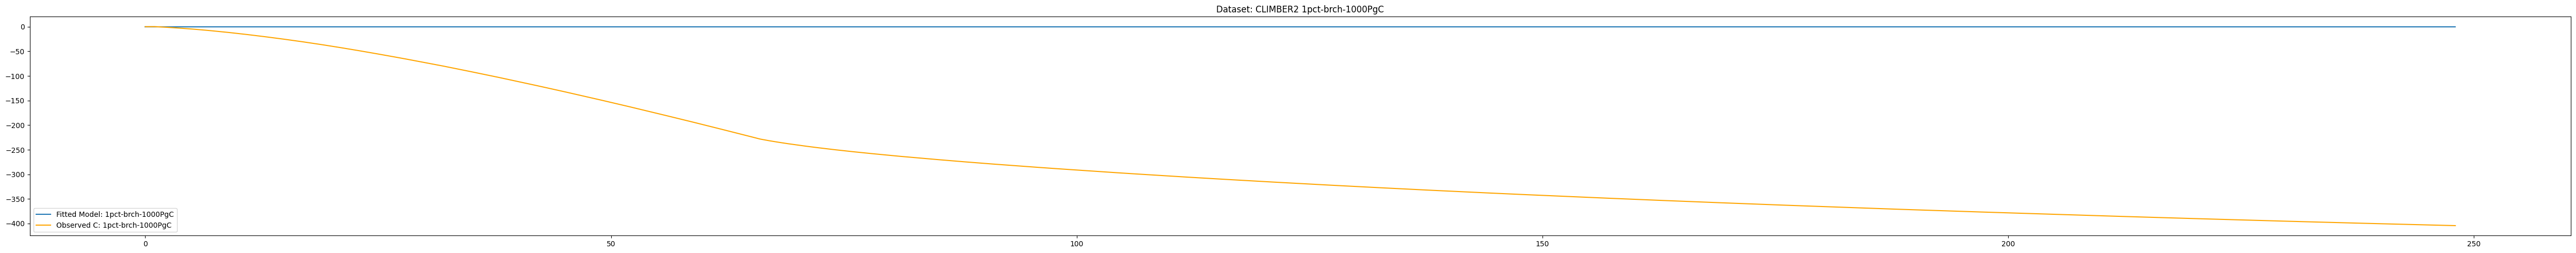

In [188]:
# Load data
datasets = ['1pct-brch-1000PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CLIMBER2/CLIMBER2_A1/fgco2_CLIMBER2_esm-1pct-brch-1000PgC_1850_2100.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CLIMBER2/CLIMBER2_A1/co2_CLIMBER2_esm-1pct-brch-1000PgC_1850_2100.csv', index_col=0).to_numpy().flatten(),
}

# Set up subplots for plotting
fig, ax = plt.subplots(1, len(datasets), figsize=(50, 5))

for i,label in enumerate(datasets):
    fgco2_data = fgco2[label]*-1
    C = np.cumsum(fgco2_data)

    conc_data = conc[label]
    time = np.arange(len(conc_data))
    
    # Ensure consistent length for fitting
    min_length = min(len(C), len(conc_data))
    C = C[:min_length]
    conc_data = conc_data[:min_length]
    time = time[:min_length]

    # Fit the curve
    popt, pcov = curve_fit(lambda t, alpha, beta, gamma: only_leave_params_to_be_set(t, alpha, beta, gamma, conc_data), 
                       time, C, p0=[1,1,1], bounds = (0, [np.inf, np.inf, np.inf]))
    # Optimized parameters
    alpha_opt, beta_opt, gamma_opt = popt
    print(f"Optimized scale values for {label}: ", alpha_opt, beta_opt, gamma_opt)
    
    # Append q values to the DataFrame
    new_scale_values = pd.DataFrame({
        'Dataset': ['MPIESM'],
        'Experiment': [label],
        'alpha': [alpha_opt],
        'beta': [beta_opt],
        'gamma': [gamma_opt]
    })
    
    # Concatenate the new q values to the main q_values_df DataFrame
    scale_values_df = pd.concat([scale_values_df, new_scale_values], ignore_index=True)
    # Output C with optimized parameters
    C_output_optimized = only_leave_params_to_be_set(time, alpha_opt, beta_opt, gamma_opt, conc_data)

    # Plot the fitted curve and observed data
    ax.plot(time, C_output_optimized, label=f'Fitted Model: {label}')
    ax.plot(time, C, 'orange', label=f'Observed C: {label}')
    ax.set_title(f'Dataset: CLIMBER2 {label}')
    ax.legend()

# Adjust layout and show plot
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()
plt.savefig('Dataset: CLIMBER2')
plt.show()


Optimized scaling values for 1pctCO2:  3.0014313622640634 3.014914083944257e-16 3.279814426507943e-20
Optimized scaling values for 1pct-brch-1000PgC:  3.3599617396664017e-18 1.5071010687742794 6.543407072365403


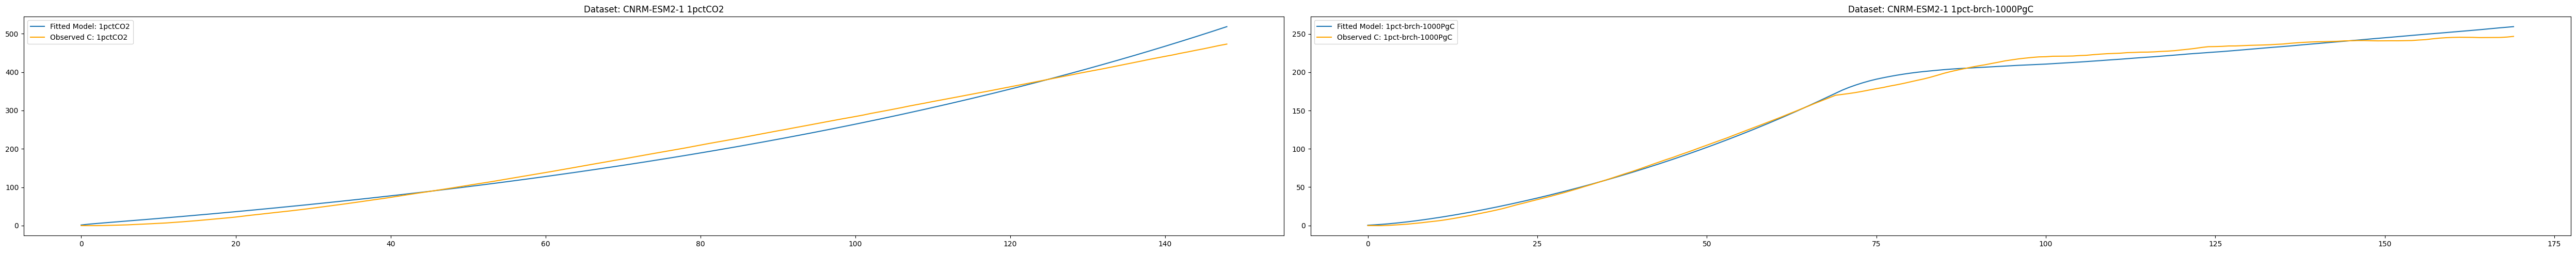

In [189]:
# Load data
datasets = ['1pctCO2', '1pct-brch-1000PgC']

fgco2 = {
    '1pctCO2': pd.read_csv('all_zecmip/CNRM-ESM2-1/CNRM_1pctCO2/fgco2_CNRM-ESM2-1_1pctCO2_r1i1p1_185001-199912.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CNRM-ESM2-1/CNRM_ZECMIP/fgco2_CNRM-ESM2-1_esm-1pct-brch-1000PgC_r1i1p1_192001-202012.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pctCO2': pd.read_csv('all_zecmip/CNRM-ESM2-1/CNRM_1pctCO2/co2_CNRM-ESM2-1_1pctCO2_r1i1p1_185001-199912.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CNRM-ESM2-1/CNRM_ZECMIP/co2_CNRM-ESM2-1_esm-1pct-brch-1000PgC_r1i1p1_192001-202012.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = step_temp_model_fitting_procedure(fgco2 = fgco2, conc = conc, datasets = datasets, dataset_name = 'CNRM-ESM2-1', scale_values_df = scale_values_df)


Optimized scaling values for 1pct-brch-1000PgC:  1.478342973914007 1.9366389980348e-14 11.854152832788124
Optimized scaling values for 1pct-brch-2000PgC:  0.406251513413028 5.3165814103559765e-21 10.58508111019779
Optimized scaling values for 1pct-brch-750PgC:  2.166282017640643 8.265999730558716e-14 11.493103245430742
Optimized scaling values for bell-1000PgC:  1.3904399158458598 2.542184022524948e-14 11.892478089243198
Optimized scaling values for bell-2000PgC:  0.2966004181384665 6.124542836805504e-19 10.532910501414898
Optimized scaling values for bell-750PgC:  2.0350681308853504 6.606607683293944e-19 11.531695340916643


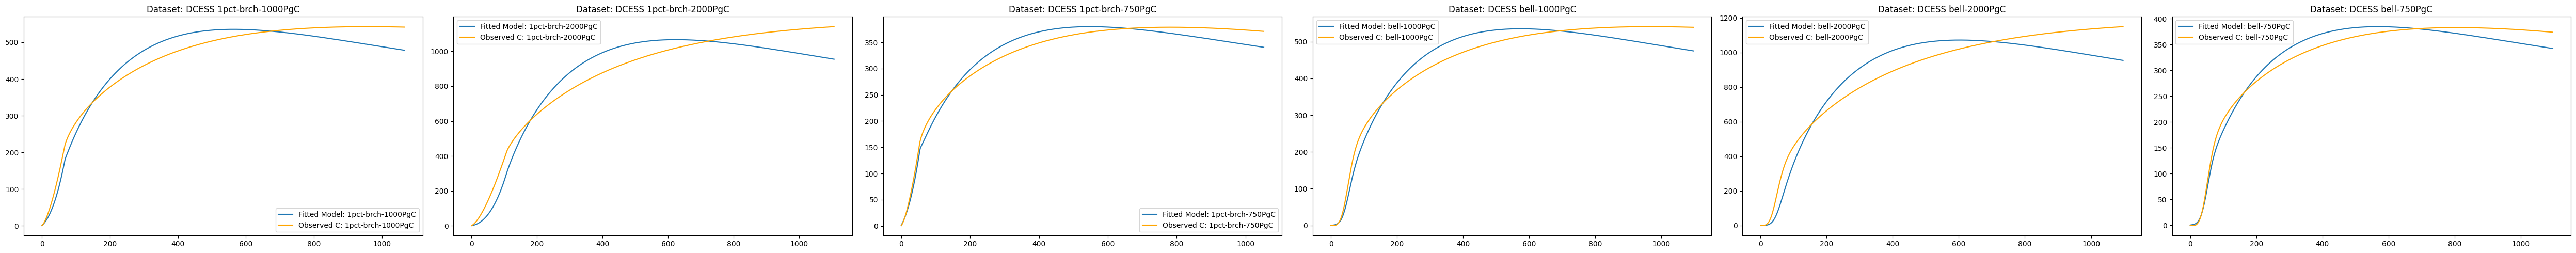

In [190]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_1pct_brch_1000PgC/fgco2_DCESS1.0_esm-1pct-brch-1000PgC_1765-2833.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_1pct_brch_2000PgC/fgco2_DCESS1.0_esm-1pct-brch-2000PgC_1765_2874.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_1pct_brch_750PgC/fgco2_DCESS1.0_esm-1pct-brch-750PgC_1765_2820.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_bell_brch_1000PgC/fgco2_DCESS1.0_esm-bell-1000PgC_1765_2864.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_bell_brch_2000PgC/fgco2_DCESS1.0_esm-bell-2000PgC_1765_2864.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_bell_brch_750PgC/fgco2_DCESS1.0_esm-bell-750PgC_1765_2864.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_1pct_brch_1000PgC/co2_DCESS1.0_esm-1pct-brch-1000PgC_1765-2833.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_1pct_brch_2000PgC/co2_DCESS1.0_esm-1pct-brch-2000PgC_1765_2874.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_1pct_brch_750PgC/co2_DCESS1.0_esm-1pct-brch-750PgC_1765_2820.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_bell_brch_1000PgC/co2_DCESS1.0_esm-bell-1000PgC_1765_2864.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_bell_brch_2000PgC/co2_DCESS1.0_esm-bell-2000PgC_1765_2864.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_bell_brch_750PgC/co2_DCESS1.0_esm-bell-750PgC_1765_2864.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = step_temp_model_fitting_procedure(dataset_name = 'DCESS', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


Optimized scaling values for 1pct-brch-1000PgC:  0.5849265176310366 1.984555499822256 11.613755647235859
Optimized scaling values for 1pct-brch-2000PgC:  3.2248338582002387 8.297832789970825e-20 8.946156755687099
Optimized scaling values for 1pct-brch-750PgC:  1.8797944376557512e-19 2.5258218303127937 11.990914140756093
Optimized scaling values for bell-1000PgC:  8.84182536742195e-14 2.325567573290182 11.566252545590237
Optimized scaling values for bell-2000PgC:  2.721922176071946 0.021168318285943698 9.0242315220042
Optimized scaling values for bell-750PgC:  6.66159706310211e-19 2.5200805280492373 12.027655031635467


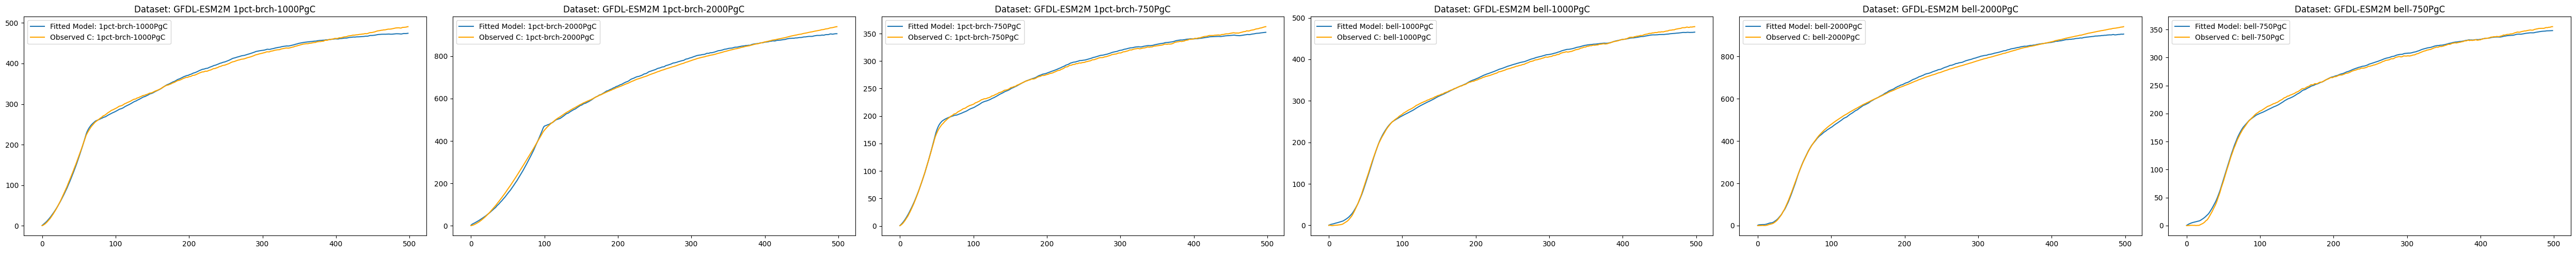

In [191]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/fgco2_GFDL-ESM2M_esm-1pct-brch-1000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/fgco2_GFDL-ESM2M_esm-1pct-brch-2000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/fgco2_GFDL-ESM2M_esm-1pct-brch-750PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/fgco2_GFDL-ESM2M_esm-bell-1000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/fgco2_GFDL-ESM2M_esm-bell-2000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/fgco2_GFDL-ESM2M_esm-bell-750PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/co2_GFDL-ESM2M_esm-1pct-brch-1000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/co2_GFDL-ESM2M_esm-1pct-brch-2000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/co2_GFDL-ESM2M_esm-1pct-brch-750PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/co2_GFDL-ESM2M_esm-bell-1000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/co2_GFDL-ESM2M_esm-bell-2000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/co2_GFDL-ESM2M_esm-bell-750PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = step_temp_model_fitting_procedure(dataset_name = 'GFDL-ESM2M', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


Optimized scaling values for 1pct-brch-1000PgC:  3.1040205293127075e-18 2.3932021446187264 11.683654639257867
Optimized scaling values for 1pct-brch-2000PgC:  3.987898737688322e-19 3.035515098268674 8.382015137867889
Optimized scaling values for 1pct-brch-750PgC:  7.744227458872869e-15 2.2268569206862856 12.488418507083312
Optimized scaling values for bell-1000PgC:  2.895695487761124e-12 2.344382168084599 11.459242542312928
Optimized scaling values for bell-2000PgC:  3.3387482017189906e-19 2.7306277503845084 8.53058786525318
Optimized scaling values for bell-750PgC:  4.409771959125993e-16 2.2515299936276527 12.080352908774401


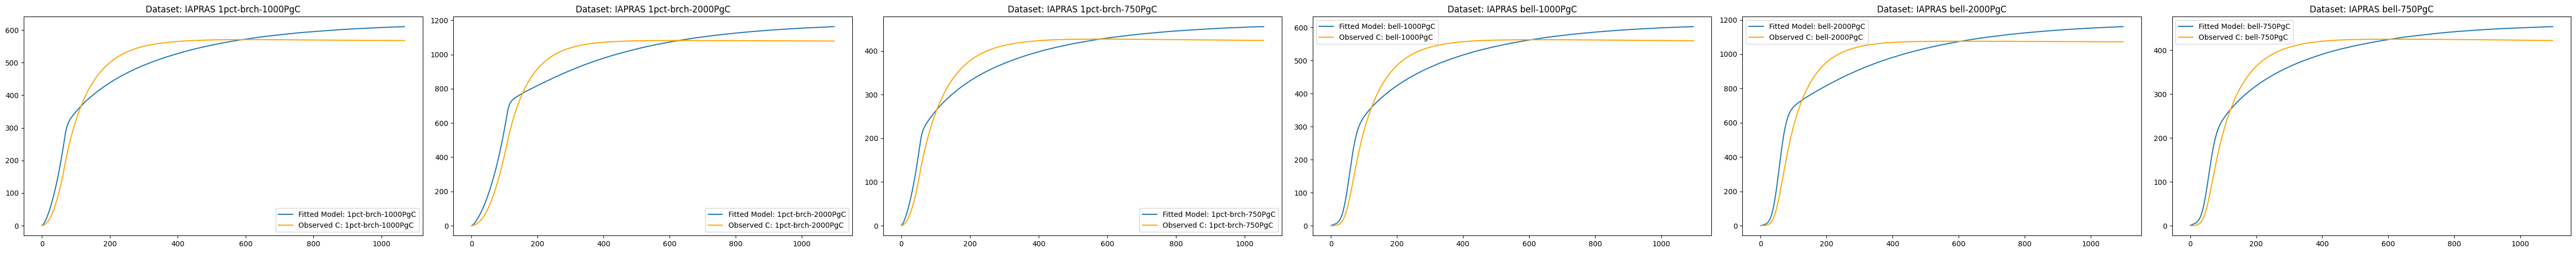

In [192]:
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/IAPRAS/abrupt-1000PgC/fgco2_IAPRAS_esm-1pct-brch-1000PgC_1_1070.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/IAPRAS/abrupt-2000PgC/fgco2_IAPRAS_esm-1pct-brch-2000PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/IAPRAS/abrupt-750PgC/fgco2_IAPRAS_esm-1pct-brch-750PgC_1_1057.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/IAPRAS/bell-1000PgC/fgco2_IAPRAS_esm-bell-1000PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/IAPRAS/bell-2000PgC/fgco2_IAPRAS_esm-bell-2000PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/IAPRAS/bell-750PgC/fgco2_IAPRAS_esm-bell-750PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/IAPRAS/abrupt-1000PgC/co2_IAPRAS_esm-1pct-brch-1000PgC_1_1070.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/IAPRAS/abrupt-2000PgC/co2_IAPRAS_esm-1pct-brch-2000PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/IAPRAS/abrupt-750PgC/co2_IAPRAS_esm-1pct-brch-750PgC_1_1057.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/IAPRAS/bell-1000PgC/co2_IAPRAS_esm-bell-1000PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/IAPRAS/bell-2000PgC/co2_IAPRAS_esm-bell-2000PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/IAPRAS/bell-750PgC/co2_IAPRAS_esm-bell-750PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = step_temp_model_fitting_procedure(dataset_name = 'IAPRAS', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


Optimized scaling values for 1pct-brch-1000PgC:  1.0882659132575023 2.141306402876892e-12 10.837628730016904
Optimized scaling values for 1pct-brch-750PgC:  1.7428999108196752 1.2948107989777092e-14 10.806522309227798


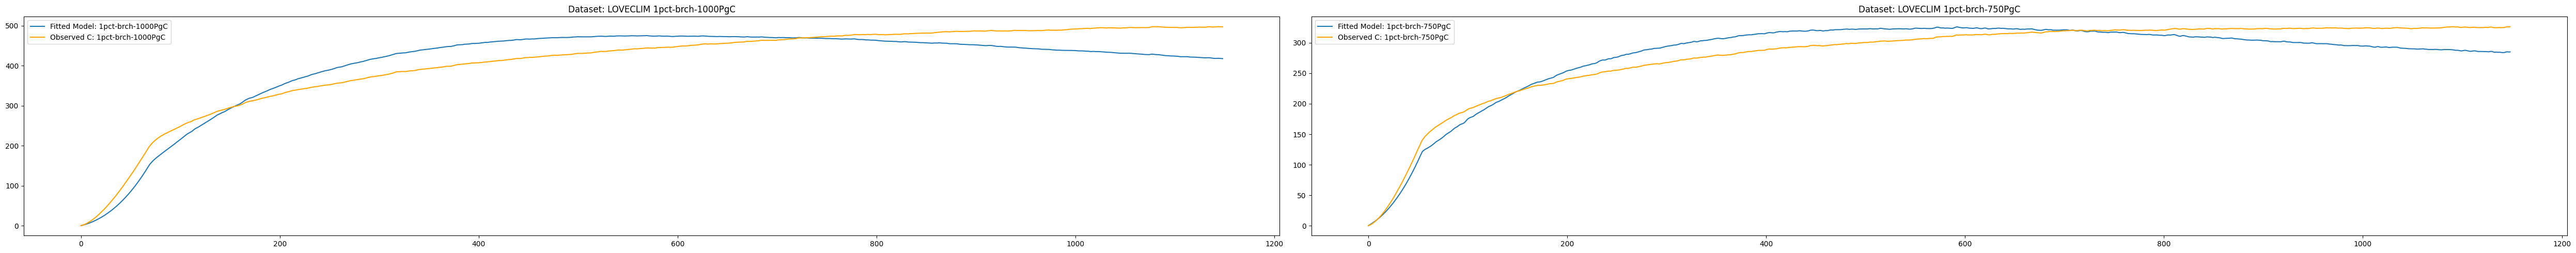

In [193]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/LOVECLIM/LOVECLIM1000PgCNew/fgco2_LOVECLIM_esm-1pct-brch-1000PgC_1850-3000.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/LOVECLIM/LOVECLIM750PgCNew/fgco2_LOVECLIM_esm-1pct-brch-750PgC_1850-3000.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/LOVECLIM/LOVECLIM1000PgCNew/co2_LOVECLIM_esm-1pct-brch-1000PgC_1850-3000.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/LOVECLIM/LOVECLIM750PgCNew/co2_LOVECLIM_esm-1pct-brch-750PgC_1850-3000.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = step_temp_model_fitting_procedure(dataset_name = 'LOVECLIM', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


Optimized scaling values for 1pct-brch-1000PgC:  3.5803822217807995e-14 2.205086493601823 13.155997673053179
Optimized scaling values for 1pct-brch-2000PgC:  3.0508293003082647 2.3230311389124177e-14 10.411589002167066
Optimized scaling values for 1pct-brch-750PgC:  2.1732855729208603e-16 2.308862073838213 13.850698575744632
Optimized scaling values for bell-1000PgC:  3.6591667123216345e-14 2.1339207896514516 13.190496610770472
Optimized scaling values for bell-2000PgC:  1.5457572285974814 0.6397550708047771 10.567663088227881
Optimized scaling values for bell-750PgC:  4.624096271499927e-19 2.2793888816011463 13.853163651602756


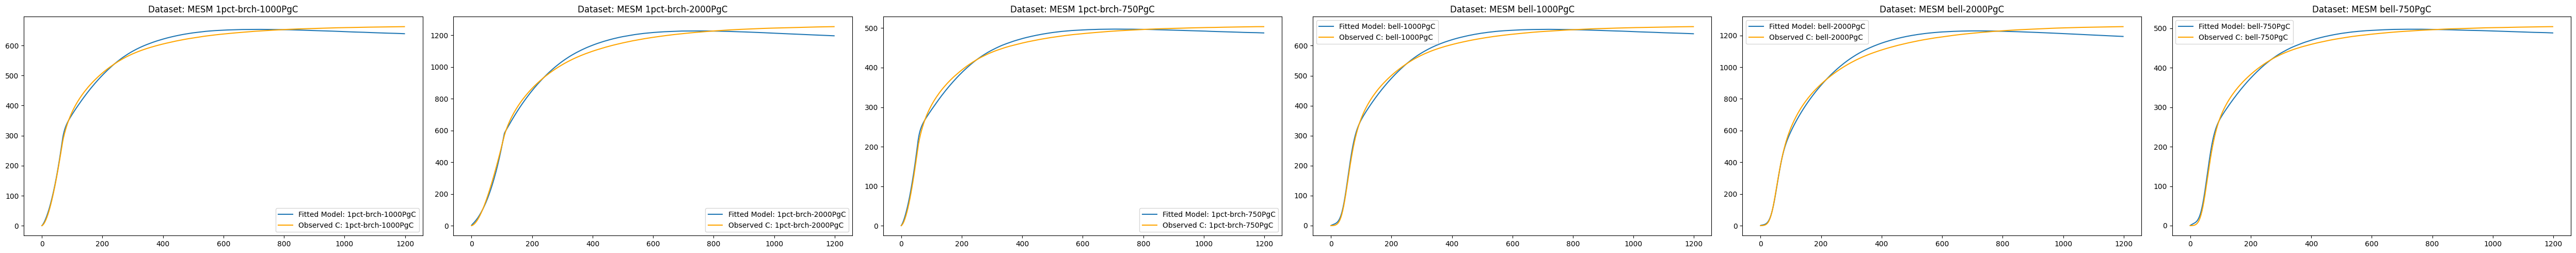

In [194]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MESM/Data_for_1%1000GtC/fgco2_MESM_esm-1pct-brch-1000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/MESM/Data_for_1%2000GtC/fgco2_MESM_esm-1pct-brch-2000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/MESM/Data_for_1%750GtC/fgco2_MESM_esm-1pct-brch-750PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/MESM/Data_for_Bell_1000/fgco2_MESM_esm-bell-1000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/MESM/Data_for_Bell_2000/fgco2_MESM_esm-bell-2000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/MESM/Data_for_Bell_750/fgco2_MESM_esm-bell-750PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MESM/Data_for_1%1000GtC/co2_MESM_esm-1pct-brch-1000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/MESM/Data_for_1%2000GtC/co2_MESM_esm-1pct-brch-2000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/MESM/Data_for_1%750GtC/co2_MESM_esm-1pct-brch-750PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/MESM/Data_for_Bell_1000/co2_MESM_esm-bell-1000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/MESM/Data_for_Bell_2000/co2_MESM_esm-bell-2000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/MESM/Data_for_Bell_750/co2_MESM_esm-bell-750PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = step_temp_model_fitting_procedure(dataset_name = 'MESM', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


Optimized scaling values for 1pct-brch-1000PgC:  2.55271725867035 0.46554261437795685 10.609303930691762
Optimized scaling values for 1pct-brch-2000PgC:  3.1134093740044504 1.6764884680505622e-20 6.559135930875505
Optimized scaling values for 1pct-brch-750PgC:  2.031868514149524 0.8101574620837135 12.11471801272371
Optimized scaling values for 1pctCO2:  4.370185006249976 8.861155510885747e-19 1.0839396347385574e-19


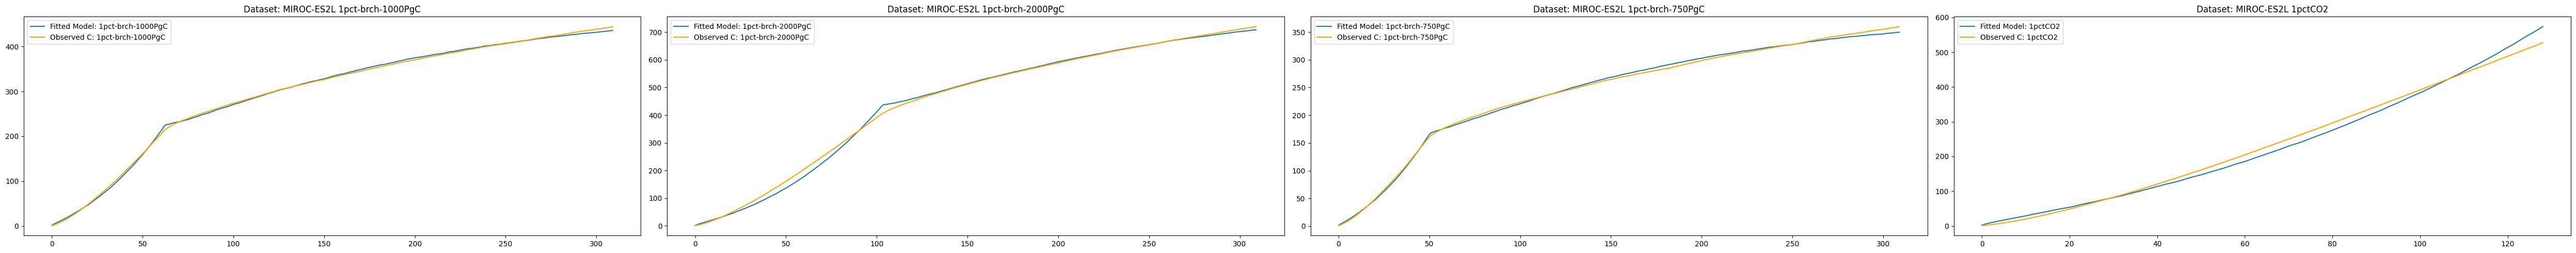

In [195]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', '1pctCO2']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MIROC-ES2L/data_MIROC-ES2L_hajima_00_190614/fgco2_MIROC-ES2L_esm-1pct-brch-1000PgC_1913_2160.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/MIROC-ES2L/data_MIROC-ES2L_hajima_00_190614/fgco2_MIROC-ES2L_esm-1pct-brch-2000PgC_1954_2160.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/MIROC-ES2L/data_MIROC-ES2L_hajima_00_190614/fgco2_MIROC-ES2L_esm-1pct-brch-750PgC_1901_2160.csv', index_col=0).to_numpy().flatten(),
    '1pctCO2': pd.read_csv('all_zecmip/MIROC-ES2L/MIROC-1pct/fgco2_MIROC-ES2L_esm-1pct-brch-1ppy_1850_1979.csv', index_col=0).to_numpy().flatten(),
    }

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MIROC-ES2L/data_MIROC-ES2L_hajima_00_190614/co2_MIROC-ES2L_esm-1pct-brch-1000PgC_1913_2160.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/MIROC-ES2L/data_MIROC-ES2L_hajima_00_190614/co2_MIROC-ES2L_esm-1pct-brch-2000PgC_1954_2160.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/MIROC-ES2L/data_MIROC-ES2L_hajima_00_190614/co2_MIROC-ES2L_esm-1pct-brch-750PgC_1901_2160.csv', index_col=0).to_numpy().flatten(),
    '1pctCO2': pd.read_csv('all_zecmip/MIROC-ES2L/MIROC-1pct/co2_MIROC-ES2L_esm-1pct-brch-1ppy_1850_1979.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = step_temp_model_fitting_procedure(dataset_name = 'MIROC-ES2L', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


Optimized scaling values for 1pct-brch-1000PgC:  1.2145953734223907 3.1875910465113605e-15 19.0437478154574
Optimized scaling values for 1pct-brch-2000PgC:  0.6489059588114885 1.4376257274032074e-14 15.656047234119324
Optimized scaling values for 1pct-brch-750PgC:  1.5632376810492692 1.4482765580754355e-17 19.74705609278063
Optimized scaling values for bell-1000PgC:  1.1786839686451458 1.0986258531754896e-16 19.03009153666959
Optimized scaling values for bell-2000PgC:  0.4475574294351992 5.778431065917684e-18 15.589430997659095
Optimized scaling values for bell-750PgC:  1.564341543320431 1.4239678705420947e-17 19.71010810710336


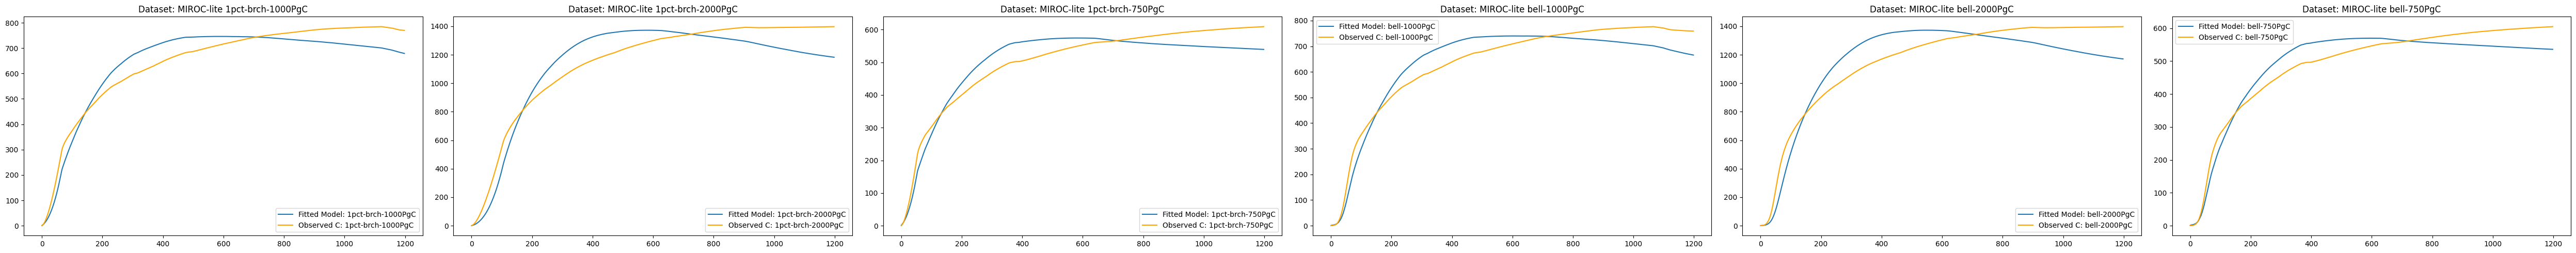

In [196]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MIROC-lite/A1_zec_1000PgC/fgco2_MIROC-lite-LCM_esm-1pct-brch-1000PgC_66-1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/MIROC-lite/A2_zec_750PgC/fgco2_MIROC-lite-LCM_esm-1pct-brch-750PgC_54-1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/MIROC-lite/A3_zec_2000PgC/fgco2_MIROC-lite-LCM_esm-1pct-brch-2000PgC_106-1200.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/MIROC-lite/B1_bellshape_1000PgC/fgco2_MIROC-lite-LCM_esm-bell-1000PgC_1-1200.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/MIROC-lite/B2_bellshape_750PgC/fgco2_MIROC-lite-LCM_esm-bell-750PgC_1-1200.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/MIROC-lite/B3_bellshape_2000PgC/fgco2_MIROC-lite-LCM_esm-bell-2000PgC_1-1200.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MIROC-lite/A1_zec_1000PgC/co2_MIROC-lite-LCM_esm-1pct-brch-1000PgC_66-1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/MIROC-lite/A2_zec_750PgC/co2_MIROC-lite-LCM_esm-1pct-brch-750PgC_54-1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/MIROC-lite/A3_zec_2000PgC/co2_MIROC-lite-LCM_esm-1pct-brch-2000PgC_106-1200.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/MIROC-lite/B1_bellshape_1000PgC/co2_MIROC-lite-LCM_esm-bell-1000PgC_1-1200.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/MIROC-lite/B2_bellshape_750PgC/co2_MIROC-lite-LCM_esm-bell-750PgC_1-1200.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/MIROC-lite/B3_bellshape_2000PgC/co2_MIROC-lite-LCM_esm-bell-2000PgC_1-1200.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = step_temp_model_fitting_procedure(dataset_name = 'MIROC-lite', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


Optimized scale values for 1pct-brch-1000PgC:  1.443808603616502 1.2458080023839828 10.706765151077544


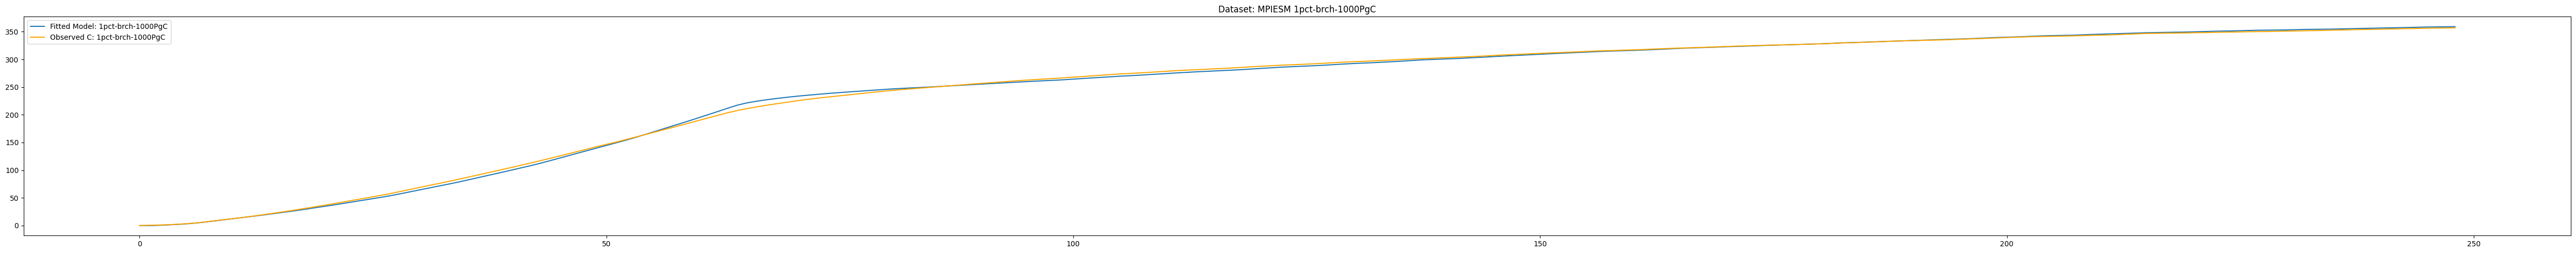

In [197]:
# Load data
datasets = ['1pct-brch-1000PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MPIESM/MPIESM_A1/fgco2_MPIESM_esm-1pct-brch-1000PgC_1850-2099.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MPIESM/MPIESM_A1/co2_MPIESM_esm-1pct-brch-1000PgC_1850-2099.csv', index_col=0).to_numpy().flatten(),
}

# Set up subplots for plotting
fig, ax = plt.subplots(1, len(datasets), figsize=(50, 5))

for i,label in enumerate(datasets):
    fgco2_data = fgco2[label]*-1
    C = np.cumsum(fgco2_data)

    conc_data = conc[label]
    time = np.arange(len(conc_data))
    
    # Ensure consistent length for fitting
    min_length = min(len(C), len(conc_data))
    C = C[:min_length]
    conc_data = conc_data[:min_length]
    time = time[:min_length]

    # Fit the curve
    popt, pcov = curve_fit(lambda t, alpha, beta, gamma: only_leave_params_to_be_set(t, alpha, beta, gamma, conc_data), 
                       time, C, p0=[1,1,1], bounds = (0, [np.inf, np.inf, np.inf]))
    # Optimized parameters
    alpha_opt, beta_opt, gamma_opt = popt
    print(f"Optimized scale values for {label}: ", alpha_opt, beta_opt, gamma_opt)
    
    # Append q values to the DataFrame
    new_scale_values = pd.DataFrame({
        'Dataset': ['MPIESM'],
        'Experiment': [label],
        'alpha': [alpha_opt],
        'beta': [beta_opt],
        'gamma': [gamma_opt]
    })
    
    # Concatenate the new q values to the main q_values_df DataFrame
    scale_values_df = pd.concat([scale_values_df, new_scale_values], ignore_index=True)
    # Output C with optimized parameters
    C_output_optimized = only_leave_params_to_be_set(time, alpha_opt, beta_opt, gamma_opt, conc_data)

    # Plot the fitted curve and observed data
    ax.plot(time, C_output_optimized, label=f'Fitted Model: {label}')
    ax.plot(time, C, 'orange', label=f'Observed C: {label}')
    ax.set_title(f'Dataset: MPIESM {label}')
    ax.legend()

# Adjust layout and show plot
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()
plt.savefig('Dataset: MPIESM')
plt.show()


Optimized scaling values for 1pct-brch-1000PgC:  1.5775920881069372 1.04607909570562 11.536094573442117
Optimized scaling values for bell-1000PgC:  1.970465723041084 0.9206324723417063 11.551395795501316
Optimized scaling values for bell-2000PgC:  2.621688233150057 2.337450852361467e-21 7.747519073988259


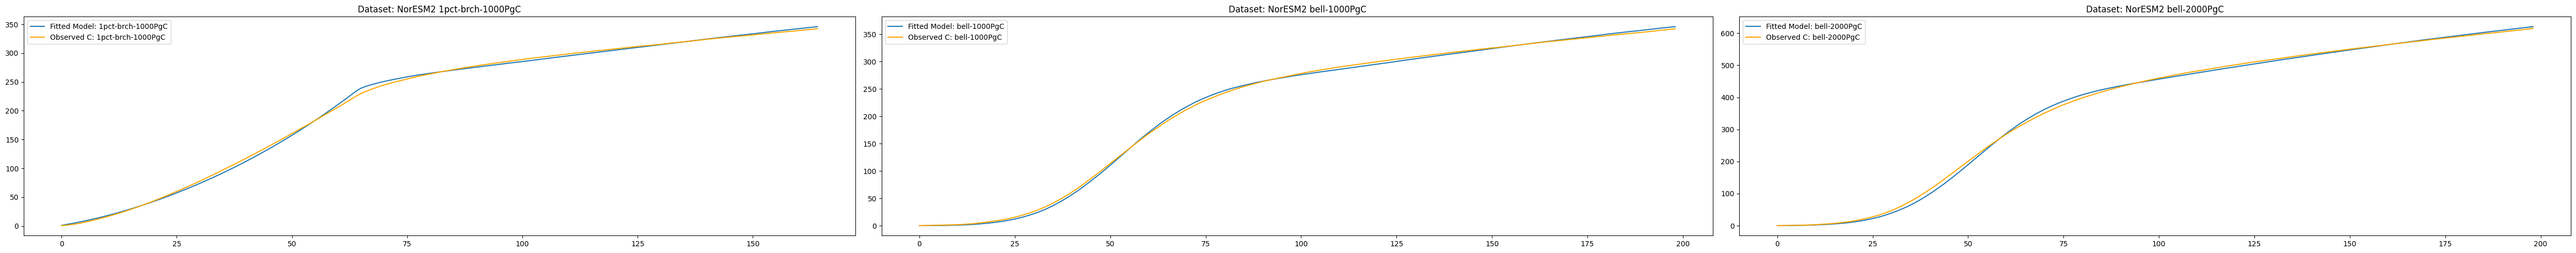

In [198]:
# Load data
datasets = ['1pct-brch-1000PgC', 'bell-1000PgC', 'bell-2000PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/NorESM2/NorESM2-A1/fgco2_NorESM2-LM_esm-1pct-brch-1000PgC_0066-0167.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/NorESM2/NorESM2-B1/fgco2_NorESM2-LM_esm-bell-1000PgC_1850-2049.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/NorESM2/NorESM2-B3/fgco2_NorESM2-LM_esm-bell-2000PgC_1850-2049.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/NorESM2/NorESM2-A1/co2_NorESM2-LM_esm-1pct-brch-1000PgC_0066-0167.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/NorESM2/NorESM2-B1/co2_NorESM2-LM_esm-bell-1000PgC_1850-2049.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/NorESM2/NorESM2-B3/co2_NorESM2-LM_esm-bell-2000PgC_1850-2049.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = step_temp_model_fitting_procedure(dataset_name = 'NorESM2', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


Optimized scaling values for 1pct-brch-1000PgC:  0.8787889260496525 1.9551138715476972 17.001084828628265
Optimized scaling values for 1pct-brch-2000PgC:  2.737401612211604 9.144461798759504e-17 13.054507843266013
Optimized scaling values for 1pct-brch-750PgC:  2.4583185176430415 0.5753349281153102 19.91446400851622
Optimized scaling values for bell-1000PgC:  0.8423588976054176 1.9394607790211598 16.967231247855146
Optimized scaling values for bell-2000PgC:  2.10530124693483 1.348766052484945e-21 13.141193377986617
Optimized scaling values for bell-750PgC:  1.2702798935914271e-15 2.828473873283675 18.08714389510209


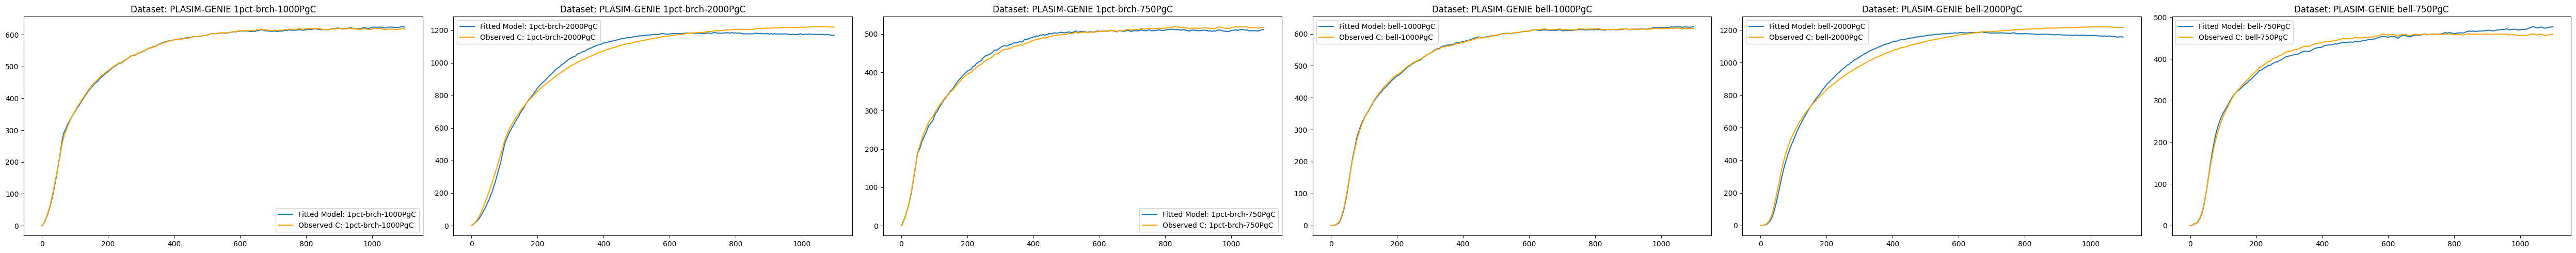

In [199]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/fgco2_PLASIM-GENIE_esm-1pct-brch-1000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/fgco2_PLASIM-GENIE_esm-1pct-brch-2000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/fgco2_PLASIM-GENIE_esm-1pct-brch-750PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/fgco2_PLASIM-GENIE_esm-bell-1000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/fgco2_PLASIM-GENIE_esm-bell-2000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/fgco2_PLASIM-GENIE_esm-bell-750PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/co2_PLASIM-GENIE_esm-1pct-brch-1000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/co2_PLASIM-GENIE_esm-1pct-brch-2000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/co2_PLASIM-GENIE_esm-1pct-brch-750PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/co2_PLASIM-GENIE_esm-bell-1000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/co2_PLASIM-GENIE_esm-bell-2000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/co2_PLASIM-GENIE_esm-bell-750PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = step_temp_model_fitting_procedure(dataset_name = 'PLASIM-GENIE', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


Optimized scaling values for 1pct-brch-1000PgC:  1.3469107725922942 1.4093752068132475 8.118509721136563
Optimized scaling values for 1pct-brch-2000PgC:  3.319764300720566 8.170043523140648e-20 4.669431563803983
Optimized scaling values for 1pct-brch-750PgC:  0.5102951791906472 2.0125972023636662 9.154042019753968
Optimized scaling values for 1pctCO2:  3.9674603803920117 1.3011310987645362e-14 3.54428788804086e-16


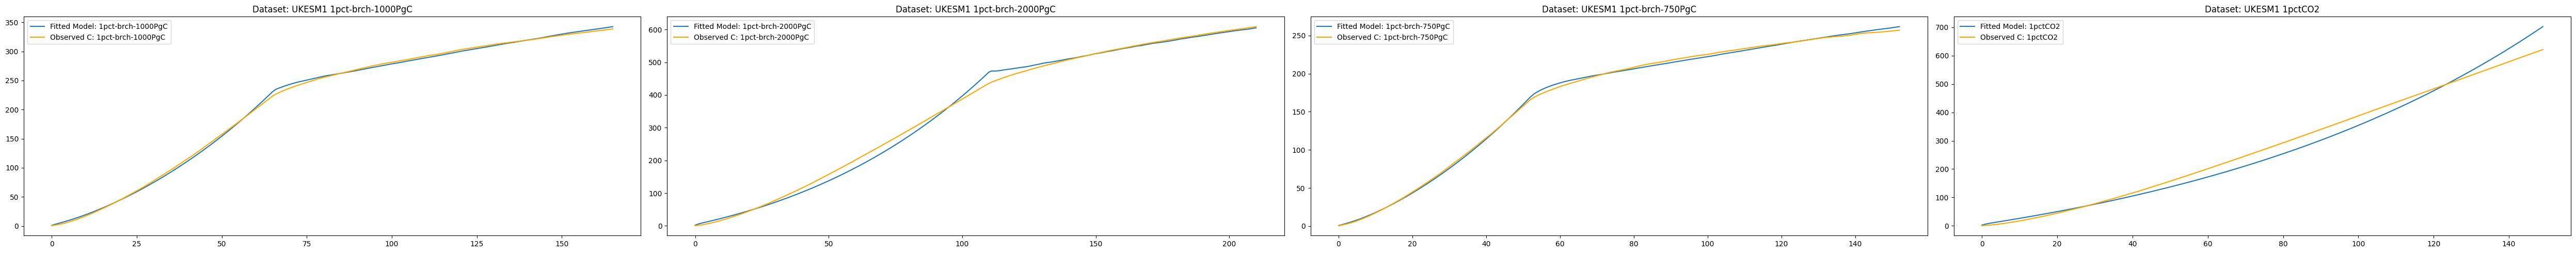

In [200]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', '1pctCO2']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/UKESM1/UKESM1_esm-1pct-brch-1000PgC/fgco2_UKESM1_esm-1pct-brch-1000PgC_1917_2016.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/UKESM1/UKESM1_esm-1pct-brch-2000PgC/fgco2_UKESM1_esm-1pct-brch-2000PgC_1962_2061.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/UKESM1/UKESM1_esm-1pct-brch-750PgC/fgco2_UKESM1_esm-1pct-brch-750PgC_1904_2003.csv', index_col=0).to_numpy().flatten(),
    '1pctCO2': pd.read_csv('all_zecmip/UKESM1/UKESM1_1pctCO2/fgco2_UKESM1_1pctCO2_1851_2000.csv', index_col=0).to_numpy().flatten(),

}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/UKESM1/UKESM1_esm-1pct-brch-1000PgC/co2_UKESM1_esm-1pct-brch-1000PgC_1917_2016.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/UKESM1/UKESM1_esm-1pct-brch-2000PgC/co2_UKESM1_esm-1pct-brch-2000PgC_1962_2061.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/UKESM1/UKESM1_esm-1pct-brch-750PgC/co2_UKESM1_esm-1pct-brch-750PgC_1904_2003.csv', index_col=0).to_numpy().flatten(),
    '1pctCO2': pd.read_csv('all_zecmip/UKESM1/UKESM1_1pctCO2/co2_UKESM1_1pctCO2_1851_2000.csv', index_col=0).to_numpy().flatten(),

}

plt , scale_values_df = step_temp_model_fitting_procedure(dataset_name = 'UKESM1', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


Optimized scaling values for 1pct-brch-1000PgC:  8.260604478762308e-16 2.6293679609400664 8.518367292292037
Optimized scaling values for 1pct-brch-2000PgC:  3.3438121592113568 1.0429731704149816e-13 5.822538141487323
Optimized scaling values for 1pct-brch-750PgC:  2.324912872566452e-17 2.7565965885199546 9.517867542149576
Optimized scaling values for bell-1000PgC:  3.1168709244386485e-13 2.5677363668094433 8.525988858046704
Optimized scaling values for bell-2000PgC:  2.8751633413432978 7.22835140593688e-11 5.972063537467891
Optimized scaling values for bell-750PgC:  8.352319988267552e-17 2.746422650103496 9.496853924040538
Optimized scaling values for 1pctCO2:  4.6706591735785254 4.663212033801268e-16 1.8541528054339483e-17


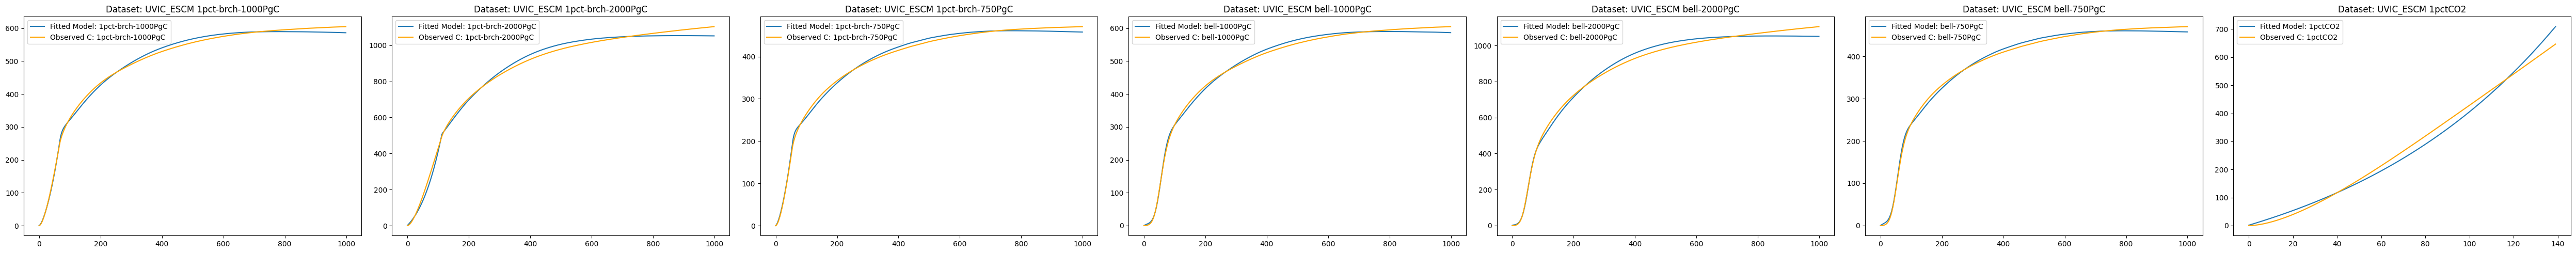

In [201]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC', '1pctCO2']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/fgco2_UVicESCM2.10_esm-1pct-brch-1000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/fgco2_UVicESCM2.10_esm-bell-2000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/fgco2_UVicESCM2.10_esm-bell-750PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/fgco2_UVicESCM2.10_esm-bell-1000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/fgco2_UVicESCM2.10_esm-1pct-brch-2000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/fgco2_UVicESCM2.10_esm-1pct-brch-750PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    '1pctCO2': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/fgco2_UVicESCM2.10_1pct_bench_1850-1989.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/co2_UVicESCM2.10_esm-1pct-brch-1000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/co2_UVicESCM2.10_esm-bell-2000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/co2_UVicESCM2.10_esm-bell-750PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/co2_UVicESCM2.10_esm-bell-1000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/co2_UVicESCM2.10_esm-1pct-brch-2000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/co2_UVicESCM2.10_esm-1pct-brch-750PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    '1pctCO2': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/co2_UVicESCM2.10_1pct_bench_1850-1989.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = step_temp_model_fitting_procedure(dataset_name = 'UVIC_ESCM', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


In [202]:
# Drop duplicate rows
scale_values_df = scale_values_df.drop_duplicates(keep='first')

# Print the cleaned DataFrame
print(scale_values_df)

scale_values_df.to_csv('scale_values.csv', index=False)

      Dataset         Experiment         alpha          beta         gamma
0     CanESM5  1pct-brch-1000PgC  8.444349e-01  1.751277e+00  8.719175e+00
1     CanESM5  1pct-brch-2000PgC  3.224682e+00  3.521409e-19  6.327444e+00
2      ACCESS            1pctCO2  4.490355e+00  8.580126e-17  9.733409e-18
3      ACCESS  1pct-brch-1000PgC  1.409784e+00  1.620935e+00  9.024242e+00
4      ACCESS   1pct-brch-750PgC  1.595115e-01  2.525723e+00  1.016233e+01
..        ...                ...           ...           ...           ...
62  UVIC_ESCM   1pct-brch-750PgC  2.324913e-17  2.756597e+00  9.517868e+00
63  UVIC_ESCM       bell-1000PgC  3.116871e-13  2.567736e+00  8.525989e+00
64  UVIC_ESCM       bell-2000PgC  2.875163e+00  7.228351e-11  5.972064e+00
65  UVIC_ESCM        bell-750PgC  8.352320e-17  2.746423e+00  9.496854e+00
66  UVIC_ESCM            1pctCO2  4.670659e+00  4.663212e-16  1.854153e-17

[67 rows x 5 columns]


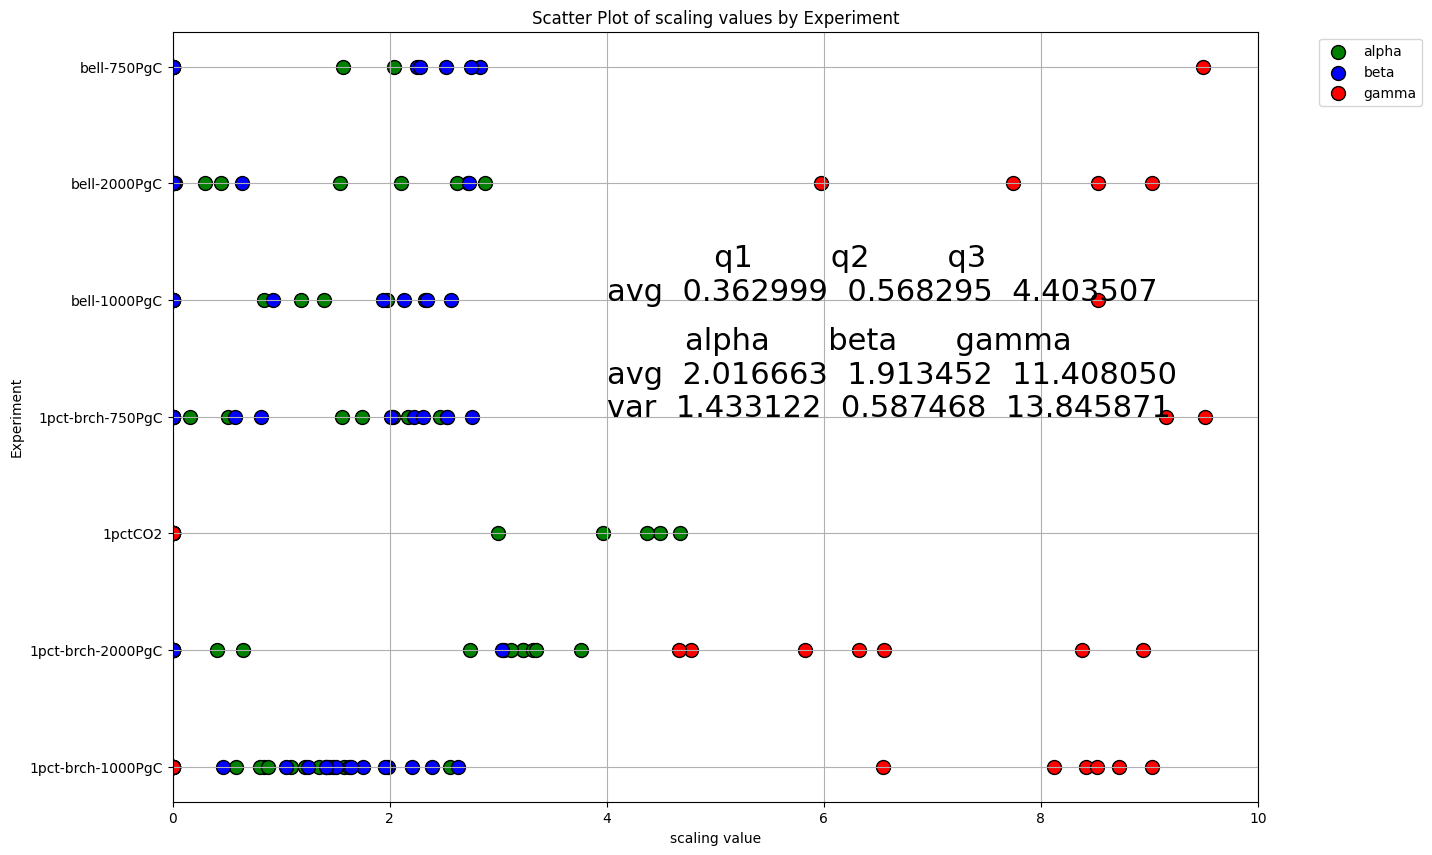

In [203]:
# Melt the DataFrame to have q values in one column
scale_values_df = pd.read_csv('/Users/mert4908/Documents/FAIR-200/notebooks/scale_values.csv')

df_melted = scale_values_df.melt(id_vars=['Dataset', 'Experiment'], value_vars=['alpha', 'beta', 'gamma'],
                    var_name='scale_value', value_name='value')

# Define colors for each q value
scale_colors = {
    'alpha': 'green',
    'beta': 'blue',
    'gamma': 'red'}

# Plotting
plt.figure(figsize=(14, 10))

# Plot each q value with its respective color
for scale_val, color in scale_colors.items():
    subset = df_melted[df_melted['scale_value'] == scale_val]
    plt.scatter(subset['value'], subset['Experiment'], 
                marker='o', color=color, 
                s=100,  # Size of scatter points
                label=scale_val,
                edgecolor='k')

plt.xlabel('scaling value')
plt.ylabel('Experiment')
plt.title('Scatter Plot of scaling values by Experiment')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.xlim(0, 10)
plt.grid(True)


#scale_values_df[scale_values_df[['alpha', 'beta', 'gamma']] > 10] = np.nan #can we do this?

scale_values_df = scale_values_df.round(decimals=6)

scale_values_df = scale_values_df.replace(0, np.nan)

stats_desc = pd.DataFrame([[scale_values_df.loc[:, 'alpha'].mean().round(decimals=6), scale_values_df.loc[:, 'beta'].mean().round(decimals=6), scale_values_df.loc[:, 'gamma'].mean().round(decimals=6)], 
                      [((scale_values_df.loc[:, 'alpha'])).var().round(decimals=6), ((scale_values_df.loc[:, 'beta'])).var().round(decimals=6), ((scale_values_df.loc[:, 'gamma'])).var().round(decimals=6)]], ['avg', 'var'], ['alpha', 'beta', 'gamma'])

qs_desc = pd.DataFrame(stats_desc.iloc[0,:]*([0.180, 0.297, 0.386]))
qs_desc = qs_desc.transpose()
qs_desc = qs_desc.rename(columns={'alpha': "q1", 'beta': "q2", 'gamma': "q3"})

plt.text(4,3,(stats_desc), fontsize = 22)
plt.text(4,4,(qs_desc), fontsize = 22)
plt.savefig('Scaling Distribution Qs')
plt.show()

